Import the data

In [4]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_iris
import seaborn as sns
import matplotlib as plt

In [3]:
df = load_iris(return_X_y = True, as_frame = True)
df = pd.concat((df[0], df[1]), axis = 1)
df = pd.concat((df, pd.get_dummies(df['target'], prefix = 'target')), axis = 1)

Perform Correlation Analysis

<Axes: >

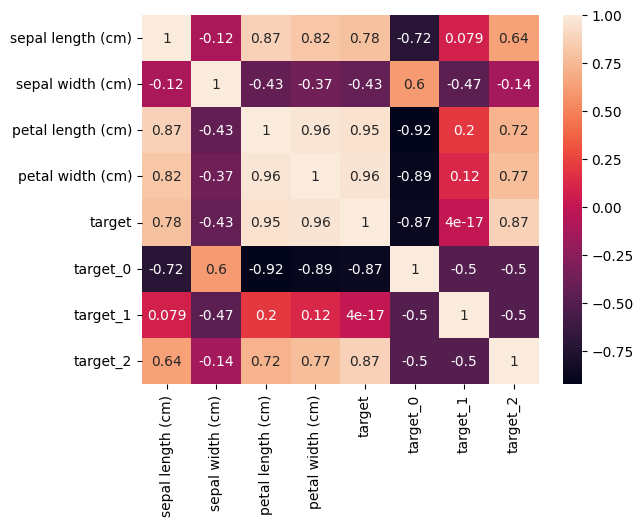

In [5]:
sns.heatmap(df.corr(), annot=True)

Here '0 : Setosa', '1: Versicolor', '2: Virginica'

As 